In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
import random as rn
import pathlib
import random
import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from keras.models import load_model


In [2]:
%%time
path_train = r"../datasets/esp32_motor/training"
path_val = r"../datasets/esp32_motor/validation"
datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    brightness_range=[1,0.6],
    channel_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)
train_generator=datagen.flow_from_directory(directory=path_train, color_mode = 'rgb', 
                                            class_mode="categorical",
                                            shuffle=True,
                                            target_size=(320,480), 
                                            batch_size=32)
validation_generator=datagen.flow_from_directory(directory=path_val, color_mode = 'rgb', 
                                            class_mode="categorical",
                                            shuffle=True,
                                            target_size=(320,480), 
                                            batch_size=32)

Found 660 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Wall time: 47 ms


In [3]:
from collections import Counter

counter = Counter(train_generator.classes)
print(counter.items())

counter = Counter(validation_generator.classes)
print(counter.items())

dict_items([(0, 430), (1, 230)])
dict_items([(0, 195), (1, 170)])


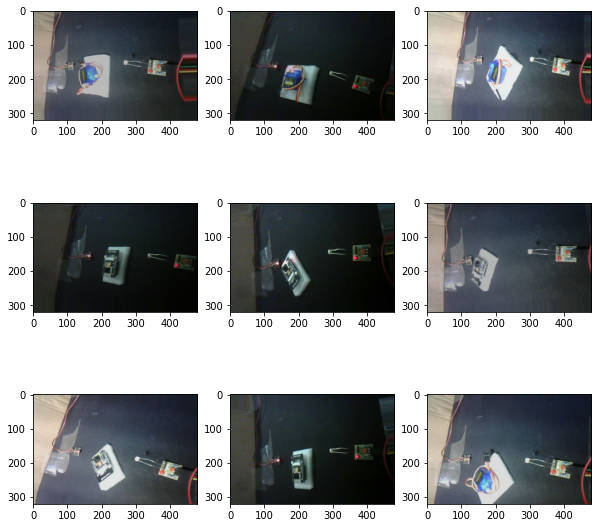

In [4]:
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):    
    img, label = train_generator.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow((img[0] * 255).astype(np.uint8))
plt.show()

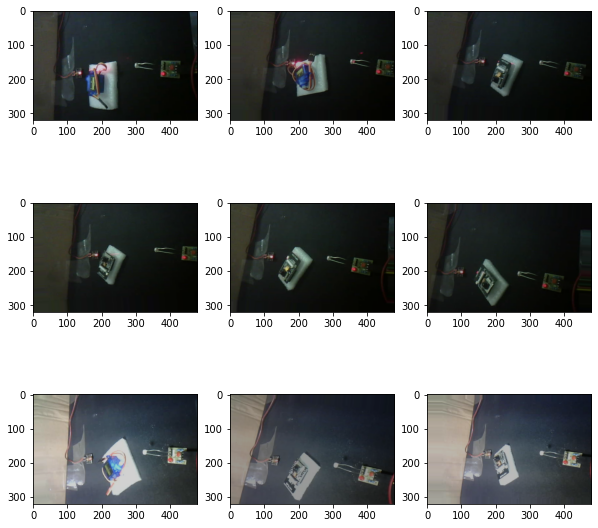

In [5]:
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):    
    img, label = validation_generator.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow((img[0] * 255).astype(np.uint8))
plt.show()

In [6]:
base_model = VGG16(include_top=False, 
                   weights='imagenet', 
                   input_shape=(320,480,3), 
                   pooling=None)

for layer in base_model.layers:
    layer.trainable = False

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 120, 128)      0     

In [8]:
cust_model = Sequential()
cust_model.add(base_model)
cust_model.add(Conv2D(filters=32,
                      kernel_size=(3,3),
                      strides=(1,1),
                      activation='relu',
                      kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                      name='Cust_Conv1'))
cust_model.add(MaxPool2D(pool_size=(2,2),
                         strides=(2,2),
                         name='Cust_Pool1'))
cust_model.add(Flatten())
cust_model.add(Dense(units=128,
                     activation='relu',
                     kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),
                     name='Cust_FC1'))
cust_model.add(Dense(units=64,
                     activation='relu',
                     kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),
                     name='Cust_FC2'))

cust_model.add(Dropout(0.3))

cust_model.add(Flatten())

cust_model.add(Dense(units=2,
                     activation='sigmoid',
                     kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),
                     name='Output'))
print(cust_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 10, 15, 512)       14714688  
_________________________________________________________________
Cust_Conv1 (Conv2D)          (None, 8, 13, 32)         147488    
_________________________________________________________________
Cust_Pool1 (MaxPooling2D)    (None, 4, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
Cust_FC1 (Dense)             (None, 128)               98432     
_________________________________________________________________
Cust_FC2 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [9]:
cust_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',                 
                   metrics=['accuracy'])

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

20
11


In [11]:
history = cust_model.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_data = validation_generator, 
    validation_steps = STEP_SIZE_VALID,
    epochs = 3)


Epoch 1/3
20/20 [==============================] - 53s 2s/step - loss: 0.6169 - accuracy: 0.6863 - val_loss: 0.6005 - val_accuracy: 0.5994
Epoch 2/3
20/20 [==============================] - 33s 2s/step - loss: 0.4403 - accuracy: 0.8313 - val_loss: 0.4090 - val_accuracy: 0.8920
Epoch 3/3
20/20 [==============================] - 33s 2s/step - loss: 0.2659 - accuracy: 0.9490 - val_loss: 0.2093 - val_accuracy: 0.9773


In [12]:
path_test = r"../datasets/esp32_motor/tests"
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(directory=path_test, color_mode = 'rgb', 
                                            class_mode="categorical",
                                            shuffle=False,
                                            target_size=(320,480), 
                                            batch_size=1,
                                            seed=42)

Found 162 images belonging to 2 classes.


In [13]:
counter = Counter(test_generator.classes)
print(counter.items())

dict_items([(0, 72), (1, 90)])


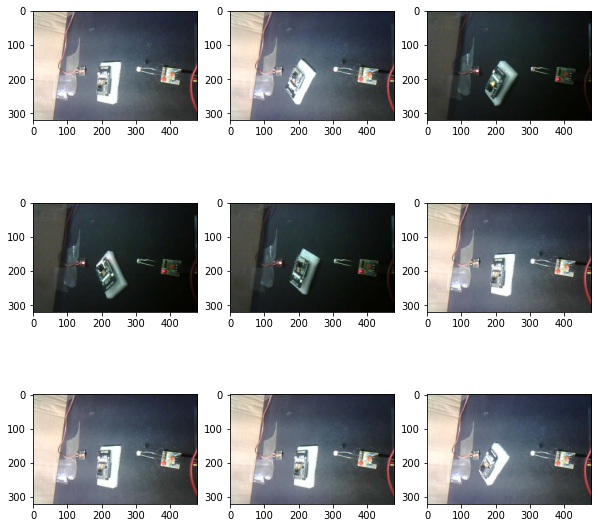

In [14]:
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):    
    img, label = test_generator.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow((img[0] * 255).astype(np.uint8))
plt.show()

In [15]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST

162

In [16]:
cust_model.evaluate(test_generator,
steps=STEP_SIZE_TEST)

162/162 [==============================] - 4s 17ms/step - loss: 0.1164 - accuracy: 1.0000


[0.11640733480453491, 1.0]

In [17]:
cust_model.save("model_esp32_motor.h5", save_format="h5")

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

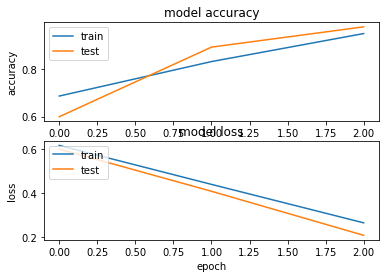

In [19]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

{'esp32': 0, 'motor': 1}
24576/8284 [=========================================================================================] - 0s 0us/step
downloaded C:\Users\Murilo\.keras\datasets\a939704f-2c3a-4213-b7ef-18f4b8e50df6
prediction: [[9.9973124e-01 1.0759538e-06]]
This image most likely belongs to esp32 with a 99.973 percent confidence.


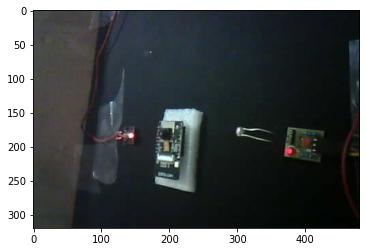

In [20]:
import uuid
import keras

print(validation_generator.class_indices)
inv_classes = validation_generator.class_indices
classes = {v: k for k, v in inv_classes.items()}

capture_url = "http://192.168.0.121/capture"
capture_path = tf.keras.utils.get_file(str(uuid.uuid4()), origin=capture_url)
# capture_path = "./datasets/fruits-360-original-size/Test/cucumber_1/r0_3.jpg" 

print(f'downloaded {capture_path}')

img = keras.preprocessing.image.load_img(
    capture_path, target_size=(320,480)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = cust_model.predict(img_array)

print(f'prediction: {predictions}')

score = predictions[0]

plt.imshow(img)

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(classes[np.argmax(score)], 100 * float(np.max(score)))
)